**The purpose of this notebook is to classify job changes as lateral, promotion, demotion, or exit.**

# Set Up

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in data

In [ ]:
# File path to get data
file_path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_AuditConsultCategorized_employ_with_yrs_exp.gz'

# Read the compressed CSV file back into a df
df = pd.read_csv(file_path, compression='gzip')
df.head()

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False
1,388.0,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True


In [ ]:
df.shape # should have 554,716 rows by 12 columns

(554716, 12)

# Copy DF

In [ ]:
# Copy over entire df to make edits. Want to keep the original df the same.
df2 = df.copy()

df2.head()

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False
1,388.0,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True


In [ ]:
df2.dtypes

id                         float64
onet                        object
Title1                      object
Title2                      object
start_dt                    object
end_dt                      object
deloitte_ind                 int64
Categorization              object
new_end_dt                  object
Total_Audit_Years          float64
Total_Consulting_Years     float64
Audit_Focused_Indicator       bool
dtype: object

# Exit Move

In [ ]:
df2['start_dt'] = pd.to_datetime(df2['start_dt'])
df2['new_end_dt'] = pd.to_datetime(df2['new_end_dt'])

# Sort the df by id and start date
df2.sort_values(by=['id', 'start_dt'], inplace=True)

# Identify exits based on the specified conditions
# Checks if the current job has deloitte_ind == 1 (which means it is a Deloite job),
# then next job has deloitte_ind == 0 (nonDeloitte job), and the start date of the next job
# is after the end date of the current job. If the conditions are met, label the 'exit' column as True
# indicating that the person has left Deloitte for another job outside Deloitte.
df2['Exit'] = (df2['deloitte_ind'] == 1) & (df2['deloitte_ind'].shift(-1) == 0) & (df2['start_dt'].shift(-1) > df2['new_end_dt']) # label true or false. Counts come from this column

# Group by occupation and year to calculate counts and rates
# For each group, calculate the sum and count of the exit column.
# The sum represents the number of True values (exits), and count represents the total number of rows in the group
exit_analysis = df2.groupby(['onet', df2['start_dt'].dt.year])['Exit'].agg(['sum', 'count']).reset_index()

# Calculate exit rate as the ratio of number of exits / total count, amt of rows
exit_analysis['Exit_Rate'] = exit_analysis['sum'] / exit_analysis['count']

# Rename columns
exit_analysis.columns = ['Occupation', 'Year', 'Exit_Count', 'Total_Count', 'Exit_Rate']

exit_analysis # 1207 rows x 5 col

,Occupation,Year,Exit_Count,Total_Count,Exit_Rate
0,11-2021.00,1900.0,1,1,1.00
1,11-2021.00,1958.0,0,1,0.00
2,11-2021.00,1966.0,0,2,0.00
3,11-2021.00,1967.0,1,2,0.50
4,11-2021.00,1968.0,1,4,0.25
...,...,...,...,...,...
1202,43-9041.00,2011.0,0,1,0.00
1203,43-9041.00,2012.0,0,1,0.00
1204,43-9041.00,2013.0,0,1,0.00
1205,43-9041.00,2014.0,0,1,0.00


# Validate Exit Analysis

In [ ]:
df.head() # original df

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False
1,388.0,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True


In [ ]:
df2.head() # edited df

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,388.0,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False


In [ ]:
# Validate analysis
# Let's look specifically at ONET value 11-2021.00 during the year 1968. Let's pull up that data
# The result from the exit analysis if there is 1 exit count True, 4 total count and a 0.25 exit rate
df['start_dt'] = pd.to_datetime(df['start_dt'])

# Filter rows based on conditions
validation_df = df[(df['start_dt'].dt.year == 1968) & (df['onet'] == '11-2021.00')]

validation_df

# Need to use df2 instead to see exit column

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
177114,2.649136e+13,11-2021.00,Account Manager (Arts Design Entertainment Spo...,Account Manager,1968-01-01,1981-01-01,0,Consulting,1981-01-01 00:00:00.000000,0.0,13.002053,False
225364,3.378421e+13,11-2021.00,Marketing Manager,Marketing Manager,1968-03-01,1996-01-01,1,Consulting,1996-01-01 00:00:00.000000,0.0,27.835729,False
432554,6.484542e+13,11-2021.00,General Manager (Management),Manager,1968-01-01,1987-01-01,0,Consulting,1987-01-01 00:00:00.000000,0.0,19.000684,False
470613,7.765301e+13,11-2021.00,Laboratory Manager,Expediter,1968-10-14,1971-11-14,0,Consulting,1971-11-14 00:00:00.000000,0.0,3.082820,False


In [ ]:
validation_df2 = df2[(df2['start_dt'].dt.year == 1968) & (df2['onet'] == '11-2021.00')]
validation_df2

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
177114,2.649136e+13,11-2021.00,Account Manager (Arts Design Entertainment Spo...,Account Manager,1968-01-01,1981-01-01,0,Consulting,1981-01-01,0.0,13.002053,False,False
225364,3.378421e+13,11-2021.00,Marketing Manager,Marketing Manager,1968-03-01,1996-01-01,1,Consulting,1996-01-01,0.0,27.835729,False,True
432554,6.484542e+13,11-2021.00,General Manager (Management),Manager,1968-01-01,1987-01-01,0,Consulting,1987-01-01,0.0,19.000684,False,False
470613,7.765301e+13,11-2021.00,Laboratory Manager,Expediter,1968-10-14,1971-11-14,0,Consulting,1971-11-14,0.0,3.082820,False,False


Yes counts and ratio is right with 1 true exit and 4 total rows so 1/4 = 0.25 for this occupation and year. Lets now confirm we are labelling Exit boolean column correctly.

In [ ]:
# Let's look at a specific ID
id = 1813.0

validation_df3 = df2[(df2['id'] == id)]
validation_df3

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False


Exit is True if leave Deloitte for another job and has a sequential start date. This is bc we only care about if they leave Deloitte, not leave other jobs.

In [ ]:
# Another validation check of Exit analysis. Check is Exit boolean is labelling correctly
# Let's look at a specific ID
id = 36.0

validation_df4 = df2[(df2['id'] == id)]
validation_df4

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.0,5.664613,False,False


Yes, Exit boolean is labelling correctly.

# Promotion/Lateral Move
Categorize job transitions as promotions if more people move from job A to job B than from B to A, and as lateral moves if there is a more balanced flow between A to C and C to A.


In [ ]:
df2.head()

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,388.0,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False


In [ ]:
# only want moves when employees worked at Deloitte so when deloitte_ind = 1
deloitte_df = df2[df2['deloitte_ind'] == 1]
deloitte_df # 174,425 rows × 13 columns

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
5,2.094000e+03,13-2011.01,Financial Analyst,Associate,2010-11-01,2014-01-01,1,Auditing,2014-01-01 00:00:00.000000,3.167693,0.000000,True,False
7,2.964000e+03,13-1111.00,Business Advisor,Advisor,2014-01-01,2015-08-01,1,Consulting,2015-08-01 00:00:00.000000,0.000000,1.579740,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554700,1.374304e+14,13-2011.02,Audit Analyst,Audit Intern,2001-09-01,2005-05-01,1,Auditing,2005-05-01 00:00:00.000000,3.663244,0.000000,False,True
554705,1.374304e+14,13-1111.00,Building Consultant,Consultant,2016-08-01,2018-08-01,1,Consulting,2018-08-01 00:00:00.000000,0.000000,1.998631,True,False
554706,1.374304e+14,13-2011.02,Senior IT Consultant,Consultant,2018-08-01,NaN,1,Auditing,2024-03-31 18:14:01.728448,5.664613,0.000000,True,False
554707,1.374304e+14,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-02-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,6.160164,False,False


In [ ]:
# now sort by id and start date
df_sorted = deloitte_df.sort_values(by=['id', 'start_dt'])
df_sorted

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
5,2.094000e+03,13-2011.01,Financial Analyst,Associate,2010-11-01,2014-01-01,1,Auditing,2014-01-01 00:00:00.000000,3.167693,0.000000,True,False
7,2.964000e+03,13-1111.00,Business Advisor,Advisor,2014-01-01,2015-08-01,1,Consulting,2015-08-01 00:00:00.000000,0.000000,1.579740,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554700,1.374304e+14,13-2011.02,Audit Analyst,Audit Intern,2001-09-01,2005-05-01,1,Auditing,2005-05-01 00:00:00.000000,3.663244,0.000000,False,True
554705,1.374304e+14,13-1111.00,Building Consultant,Consultant,2016-08-01,2018-08-01,1,Consulting,2018-08-01 00:00:00.000000,0.000000,1.998631,True,False
554706,1.374304e+14,13-2011.02,Senior IT Consultant,Consultant,2018-08-01,NaN,1,Auditing,2024-03-31 18:14:01.728448,5.664613,0.000000,True,False
554707,1.374304e+14,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-02-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,6.160164,False,False


## Dummy Dataset

In [ ]:
# First let's try this analysis on a dummy dataset. The idea for this analysis is the
# following to get the ratios. Then we will apply a threshold baaed on Ratios
# to label job transitions as either promotion, demotion, or lateral move.

# Origin   Destination Count   Other Direction (From Table Below)   Total Moves     Ratio (Count/Total Moves)
# Analyst    Analyst      2                  2                           4 bc 2+2            2/4
# Analyst     BIE         1                  2                           3 bc 1+2            1/3
# BIE        Analyst      2                  1                           3                   2/3

# Origin   Destination   Count
# Analyst   Analyst       2
# Analyst     BIE         1
# BIE       Analyst       2

In [ ]:
# Create Dummy Dataset
dummy = {
    'id': [1, 1, 2, 2, 3, 3, 1, 2,4,4], # added last record to test if start_dt of new job is AFTER end_dt of previous job
    'title': ['Analyst', 'BIE', 'Analyst', 'BIE', 'BIE', 'Analyst', 'Manager','Manager', 'Analyst', 'BIE'],
    'start_dt': ['2022-01-01', '2022-03-01', '2022-01-01', '2022-03-01', '2022-01-15', '2022-04-01','2022-07-01','2022-04-01', '2022-06-01','2022-10-02'],
    'end_dt': ['2022-02-01', '2022-06-01', '2022-02-15', '2022-06-01', '2022-03-01', '2022-06-01', '2022-10-01', '2022-07-01','2002-08-01','2022-12-01']
}

dummy_df = pd.DataFrame(dummy)

dummy_df

,id,title,start_dt,end_dt
0,1,Analyst,2022-01-01,2022-02-01
1,1,BIE,2022-03-01,2022-06-01
2,2,Analyst,2022-01-01,2022-02-15
3,2,BIE,2022-03-01,2022-06-01
4,3,BIE,2022-01-15,2022-03-01
5,3,Analyst,2022-04-01,2022-06-01
6,1,Manager,2022-07-01,2022-10-01
7,2,Manager,2022-04-01,2022-07-01
8,4,Analyst,2022-06-01,2002-08-01
9,4,BIE,2022-10-02,2022-12-01


In [ ]:
# PreProcess dummy df
dummy_df['start_dt'] = pd.to_datetime(dummy_df['start_dt'])
dummy_df['end_dt'] = pd.to_datetime(dummy_df['end_dt'])

dummy_df

,id,title,start_dt,end_dt
0,1,Analyst,2022-01-01,2022-02-01
1,1,BIE,2022-03-01,2022-06-01
2,2,Analyst,2022-01-01,2022-02-15
3,2,BIE,2022-03-01,2022-06-01
4,3,BIE,2022-01-15,2022-03-01
5,3,Analyst,2022-04-01,2022-06-01
6,1,Manager,2022-07-01,2022-10-01
7,2,Manager,2022-04-01,2022-07-01
8,4,Analyst,2022-06-01,2002-08-01
9,4,BIE,2022-10-02,2022-12-01


In [ ]:
sort_dummy_df = dummy_df.sort_values(by=['id','start_dt'])
sort_dummy_df

,id,title,start_dt,end_dt
0,1,Analyst,2022-01-01,2022-02-01
1,1,BIE,2022-03-01,2022-06-01
6,1,Manager,2022-07-01,2022-10-01
2,2,Analyst,2022-01-01,2022-02-15
3,2,BIE,2022-03-01,2022-06-01
7,2,Manager,2022-04-01,2022-07-01
4,3,BIE,2022-01-15,2022-03-01
5,3,Analyst,2022-04-01,2022-06-01
8,4,Analyst,2022-06-01,2002-08-01
9,4,BIE,2022-10-02,2022-12-01


In [ ]:
# Create a new column for the previous job title
sort_dummy_df['Origin'] = sort_dummy_df.groupby('id')['title'].shift()

# Create a new df to store transitions
transitions_df = sort_dummy_df[(sort_dummy_df['title'] != sort_dummy_df['Origin']) & (sort_dummy_df['start_dt'] > sort_dummy_df['end_dt'].shift())][['Origin', 'title']]
# this ensures start date of Destination is AFTER the origin end_date

# Count transitions
transitions_count = transitions_df.groupby(['Origin', 'title']).size().reset_index().rename(columns={'title': 'Destination', 0: 'Count'})

# Now want to know when the origin and destinations happen in other direction
#transitions_count['Other Direction'] = transitions_count.apply(lambda row: transitions_count[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin'])]['Count'].sum(), axis=1)
transitions_count['Other Direction'] = transitions_count.apply(lambda row: transitions_count.loc[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin']), 'Count'].iloc[0] if not transitions_count[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin'])].empty else 0, axis=1)
# Creating Other Direction column by finding the corresponding count in the DataFrame for the inverse pair of 'Origin' and 'Destination'. If there's a match, it assigns that count to the "Other Direction" column; otherwise, if not it assigns it 0

# Add Counts column, Creates new column called total moves
transitions_count['Total Moves'] = transitions_count['Count'] + transitions_count['Other Direction']

# Calculate Ratios, Create new column called Ratio
transitions_count['Ratio'] = transitions_count['Count'] / transitions_count['Total Moves']

transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio
0,Analyst,BIE,3,1,4,0.75
1,BIE,Analyst,1,3,4,0.25
2,BIE,Manager,1,0,1,1.00


## Apply Analysis

In [ ]:
# df is already sorted by id and start date (and only Deloitte jobs) and the date
# columns were preprocessed previously to the right format during the exit analysis
df_sorted

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
5,2.094000e+03,13-2011.01,Financial Analyst,Associate,2010-11-01,2014-01-01,1,Auditing,2014-01-01 00:00:00.000000,3.167693,0.000000,True,False
7,2.964000e+03,13-1111.00,Business Advisor,Advisor,2014-01-01,2015-08-01,1,Consulting,2015-08-01 00:00:00.000000,0.000000,1.579740,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554700,1.374304e+14,13-2011.02,Audit Analyst,Audit Intern,2001-09-01,2005-05-01,1,Auditing,2005-05-01 00:00:00.000000,3.663244,0.000000,False,True
554705,1.374304e+14,13-1111.00,Building Consultant,Consultant,2016-08-01,2018-08-01,1,Consulting,2018-08-01 00:00:00.000000,0.000000,1.998631,True,False
554706,1.374304e+14,13-2011.02,Senior IT Consultant,Consultant,2018-08-01,NaN,1,Auditing,2024-03-31 18:14:01.728448,5.664613,0.000000,True,False
554707,1.374304e+14,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-02-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,6.160164,False,False


In [ ]:
# Create a new column for the previous job title
df_sorted['Origin'] = df_sorted.groupby('id')['onet'].shift()

# Create a new df to store transitions
transitions_df = df_sorted[(df_sorted['onet'] != df_sorted['Origin']) & (df_sorted['start_dt'] > df_sorted['end_dt'].shift())][['Origin', 'onet']]
# this ensures start date of Destination is AFTER the orign end_date

# Count transitions
transitions_count = transitions_df.groupby(['Origin', 'onet']).size().reset_index().rename(columns={'onet': 'Destination', 0: 'Count'})

# Now want to know when the origin and destinations happen in other direction
transitions_count['Other Direction'] = transitions_count.apply(lambda row: transitions_count.loc[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin']), 'Count'].iloc[0] if not transitions_count[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin'])].empty else 0, axis=1)

# Add Counts
transitions_count['Total Moves'] = transitions_count['Count'] + transitions_count['Other Direction']

# Calculate Ratios
transitions_count['Ratio'] = transitions_count['Count'] / transitions_count['Total Moves']

transitions_count # only for people who were working AT Deloitte

,Origin,Destination,Count,Other Direction,Total Moves,Ratio
0,11-2021.00,11-9199.02,2,3,5,0.400000
1,11-2021.00,13-1111.00,59,876,935,0.063102
2,11-2021.00,13-1141.00,1,0,1,1.000000
3,11-2021.00,13-1161.00,21,63,84,0.250000
4,11-2021.00,13-2011.01,29,110,139,0.208633
...,...,...,...,...,...,...
145,43-3031.00,13-1161.00,1,6,7,0.142857
146,43-3031.00,13-2011.01,27,20,47,0.574468
147,43-3031.00,13-2011.02,583,102,685,0.851095
148,43-3031.00,13-2051.00,3,1,4,0.750000


## Picking Bin Size

In [ ]:
import math

In [ ]:
# Square Root Rule: Number of bins ≈ sqrt(n), where n is the number of data points.
# Pros: Simple/easy to calculate
# Cons: Can be sensitive to the size of the dataset; may not capture the complexity of the data distribution.
num_bins1 = math.ceil(math.sqrt(len(transitions_count['Ratio'])))
num_bins1

13

In [ ]:
# Sturges' Formula: Number of bins = 1 + log2(n), where n is the number of data points.
# Pros: Quick/easy to calculate, suitable for datasets with a moderate number of observations.
# Cons: May not work well for small or large datasets; assumes a normal distribution.
num_bins2 = math.ceil(1 + math.log2(len(transitions_count['Ratio'])))
num_bins2

9

In [ ]:
# Scott's Rule: Bin width = 3.5 * (standard deviation) / (n^(1/3)), where n is the number of data points.
# Pros: Takes into account the standard deviation and size of the dataset; can be effective for datasets
# with varying spread.
# Cons: Sensitive to outliers; may not work well for non-normal distributions.
bin_width = 3.5 * transitions_count['Ratio'].std() / len(transitions_count['Ratio'])**(1/3)
num_bins3 = math.ceil((transitions_count['Ratio'].max() - transitions_count['Ratio'].min()) / bin_width)
num_bins3

5

In [ ]:
# Freedman-Diaconis Rule: Bin width = 2 * IQR / (n^(1/3)), where IQR is the interquartile range and
# n is the number of data points.
# Pros: Takes into account the interquartile range and size of the dataset; robust to outliers.
# Cons: May result in too many or too few bins for certain data distributions.
iqr = transitions_count['Ratio'].quantile(0.75) - transitions_count['Ratio'].quantile(0.25)
bin_width = 2 * iqr / len(transitions_count['Ratio'])**(1/3)
num_bins4 = math.ceil((transitions_count['Ratio'].max() - transitions_count['Ratio'].min()) / bin_width)
num_bins4

5

Lets see if the dataset is normally distributed to help pick what bin calculation to use.

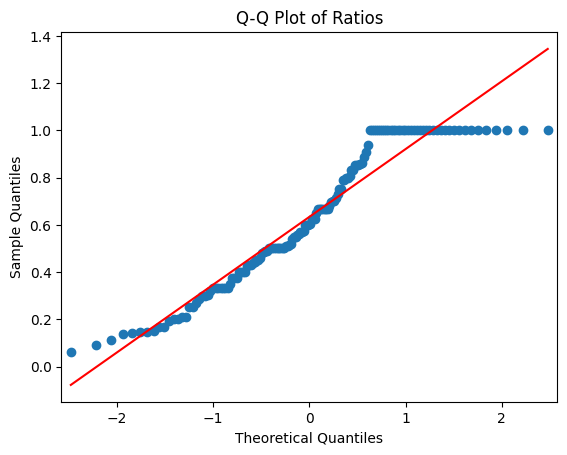

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Q-Q (Quantile-Quantile) plot compares the quantiles of the data to the quantiles of
# a theoretical normal distribution. If the data points fall along a straight line,
# it suggests that the data follows a normal distribution
sm.qqplot(transitions_count['Ratio'], line='s')
plt.title('Q-Q Plot of Ratios')
plt.show()

In [ ]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

stat, p_value = shapiro(transitions_count['Ratio'])

# Check the p-value
if p_value > 0.05:
    print("The data appears to be normally distributed (p-value =", p_value, ")")
else:
    print("The data does NOT appear to be normally distributed (p-value =", p_value, ")")


The data does NOT appear to be normally distributed (p-value = 7.986005812199437e-08 )


## Distribution of Ratios
This will help us label transition moves either as promotion, lateral, or demotion.

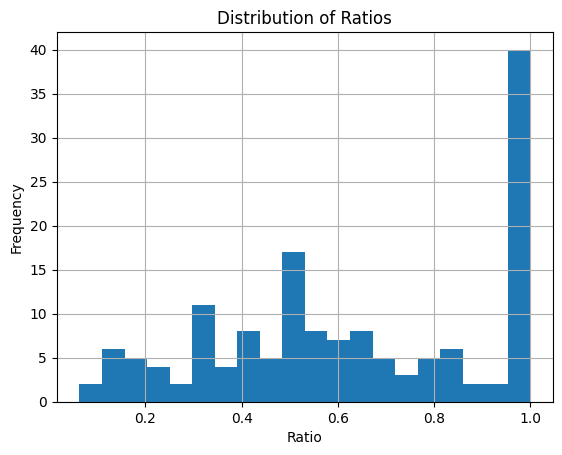

In [ ]:
transitions_count['Ratio'].hist(bins=20) # bin size .05 which in this case is 20 bc the ratios are decimals
plt.title('Distribution of Ratios')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()

Labels Threshold:

0.0 - 0.35 = Demotion

0.36 - 0.74 = Lateral

0.75 - 1.0 = Promotion


## Label Ratios

In [ ]:
transitions_count['Job Move'] = pd.cut(transitions_count['Ratio'], bins=[-float('inf'), 0.36, 0.74, float('inf')], labels=['Demotion', 'Lateral', 'Promotion'], include_lowest=True)
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,11-9199.02,2,3,5,0.400000,Lateral
1,11-2021.00,13-1111.00,59,876,935,0.063102,Demotion
2,11-2021.00,13-1141.00,1,0,1,1.000000,Promotion
3,11-2021.00,13-1161.00,21,63,84,0.250000,Demotion
4,11-2021.00,13-2011.01,29,110,139,0.208633,Demotion
...,...,...,...,...,...,...,...
145,43-3031.00,13-1161.00,1,6,7,0.142857,Demotion
146,43-3031.00,13-2011.01,27,20,47,0.574468,Lateral
147,43-3031.00,13-2011.02,583,102,685,0.851095,Promotion
148,43-3031.00,13-2051.00,3,1,4,0.750000,Promotion


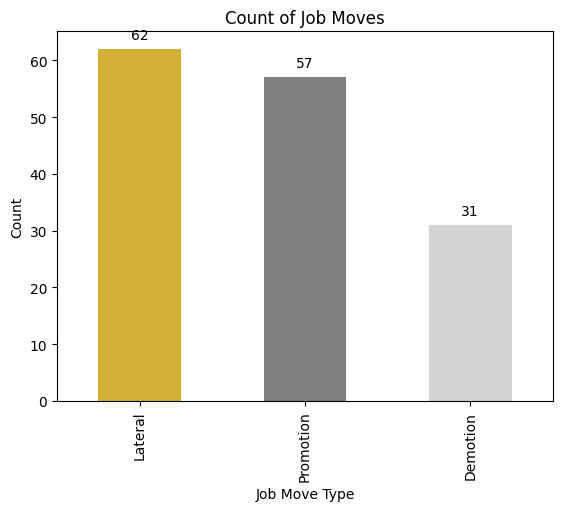

In [ ]:
job_move_counts = transitions_count['Job Move'].value_counts()

# Plot the bar chart with desired colors
ax = job_move_counts.plot(kind='bar', color=['#D4AF37', 'gray', 'lightgray'])  # Using hexadecimal color codes for honey gold and light gold
plt.title('Count of Job Moves')
plt.xlabel('Job Move Type')
plt.ylabel('Count')

# Add numeric values on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


# Merge Data

In [ ]:
df2 # includes people who have worked at nonDeloitte jobs

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1.813000e+03,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1.813000e+03,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554711,1.374304e+14,13-1111.00,Systems Manager,Managing Consultant,2005-06-01,2007-04-01,0,Consulting,2007-04-01 00:00:00.000000,0.000000,2.830938,False,False
554712,1.374304e+14,11-2021.00,Director of Product Development,Team Lead,2010-02-01,2010-07-01,0,Consulting,2010-07-01 00:00:00.000000,0.000000,3.241615,False,False
554713,1.374304e+14,11-2021.00,Vice President (VP) of Marketing,Vice President,2010-08-01,2012-07-01,0,Consulting,2012-07-01 00:00:00.000000,0.000000,5.158111,False,False
554714,1.374304e+14,11-2021.00,Business Intelligence Manager,Vice President,2012-07-01,2014-08-01,0,Consulting,2014-08-01 00:00:00.000000,0.000000,7.241615,False,False


In [ ]:
# copy df over to make edits
df3 = df2.copy()
df3

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1.813000e+03,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1.813000e+03,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554711,1.374304e+14,13-1111.00,Systems Manager,Managing Consultant,2005-06-01,2007-04-01,0,Consulting,2007-04-01 00:00:00.000000,0.000000,2.830938,False,False
554712,1.374304e+14,11-2021.00,Director of Product Development,Team Lead,2010-02-01,2010-07-01,0,Consulting,2010-07-01 00:00:00.000000,0.000000,3.241615,False,False
554713,1.374304e+14,11-2021.00,Vice President (VP) of Marketing,Vice President,2010-08-01,2012-07-01,0,Consulting,2012-07-01 00:00:00.000000,0.000000,5.158111,False,False
554714,1.374304e+14,11-2021.00,Business Intelligence Manager,Vice President,2012-07-01,2014-08-01,0,Consulting,2014-08-01 00:00:00.000000,0.000000,7.241615,False,False


In [ ]:
# check if NaT's in start date column
# There should not be any bc filled start_dt with prev job end_dt in prev classification notebook
nan = df3['start_dt'].isna()

# Create a df containing rows where NaT values are in the start_dt column
nan_rows_df = df3[nan]
nan_rows_df # there is 35,082 rows with NaT's in start_dt

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
46,8.359000e+03,13-2011.01,Tax Senior - Public,Tax Manager,NaT,NaN,1,Auditing,2024-03-31 18:14:01.728448,NaN,0.0,False,False
55,8.970000e+03,13-1111.00,Consulting Manager,\N,NaT,NaN,0,Consulting,2024-03-31 18:14:01.728448,0.0,NaN,True,False
106,8.589939e+09,13-1111.00,Business Analyst (Business and Financial Opera...,Business Analyst,NaT,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.0,NaN,False,False
119,8.589943e+09,13-2011.02,Audit Manager,Audit Manager,NaT,NaN,0,Auditing,2024-03-31 18:14:01.728448,NaN,0.0,False,False
121,8.589945e+09,13-2011.02,Risk and Assurance Manager,Guest Service Agent/Night Auditor,NaT,NaN,1,Auditing,2024-03-31 18:14:01.728448,NaN,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554644,1.373960e+14,13-2051.00,Other,Investment Banking Analyst,NaT,NaN,0,Consulting,2024-03-31 18:14:01.728448,0.0,NaN,False,False
554663,1.374046e+14,13-1111.00,Account Consultant,Associate Consultant,NaT,2017-03-28,0,Consulting,2017-03-28 00:00:00.000000,0.0,NaN,False,False
554664,1.374046e+14,13-1111.00,Account Consultant,Consultant,NaT,2017-03-28,0,Consulting,2017-03-28 00:00:00.000000,0.0,NaN,False,False
554675,1.374132e+14,13-1161.00,Business Analytics Manager,Associate,NaT,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.0,NaN,False,False


In [ ]:
# let's look at specific rows and why they are NaT's start_dt because we should have
# solved this problem already

# Let's try listing all the ids
id_column = 'id'

# Count the number of unique onet values
num_unique_ids = nan_rows_df[id_column].nunique()

# List all onet values
unique_ids = nan_rows_df[id_column].unique()

print(f"Number of unique ID values: {num_unique_ids}")
print("List of IDs:")
print(unique_ids)

Number of unique ID values: 26872
List of IDs:
[8.35900000e+03 8.97000000e+03 8.58993887e+09 ... 1.37396004e+14
 1.37404594e+14 1.37413184e+14]


In [ ]:
# let's look at a specific ID
id = unique_ids[800]

check = nan_rows_df[(nan_rows_df['id'] == id)]
check

# These rows are NaT's because:
# 1. they only have one job entry and we can not fill start or end_dts with only one data point
# 2. they have multiple data points and all have NaT for start_dt so can't infer dates

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
17540,2.611340e+12,13-2051.00,Financial Analyst,Financial Analyst,NaT,NaN,0,Consulting,2024-03-31 18:14:01.728448,0.0,NaN,False,False


In [ ]:
# drop rows with NaT start date
df3_clean = df3.dropna(subset=['start_dt'])
df3_clean  # 519634 rows × 15 columns

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,3.600000e+01,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.000000,5.664613,False,False
1,3.880000e+02,13-2099.02,Risk Control Consultant,Risk Management Consultant,2005-06-01,2008-04-01,1,Consulting,2008-04-01 00:00:00.000000,0.000000,2.833676,False,False
2,1.813000e+03,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1.813000e+03,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1.813000e+03,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554711,1.374304e+14,13-1111.00,Systems Manager,Managing Consultant,2005-06-01,2007-04-01,0,Consulting,2007-04-01 00:00:00.000000,0.000000,2.830938,False,False
554712,1.374304e+14,11-2021.00,Director of Product Development,Team Lead,2010-02-01,2010-07-01,0,Consulting,2010-07-01 00:00:00.000000,0.000000,3.241615,False,False
554713,1.374304e+14,11-2021.00,Vice President (VP) of Marketing,Vice President,2010-08-01,2012-07-01,0,Consulting,2012-07-01 00:00:00.000000,0.000000,5.158111,False,False
554714,1.374304e+14,11-2021.00,Business Intelligence Manager,Vice President,2012-07-01,2014-08-01,0,Consulting,2014-08-01 00:00:00.000000,0.000000,7.241615,False,False


In [ ]:
df2.shape # check how many rows lost. Should be this 554716 - 35082 = 519634 rows.
# this is good

(554716, 13)

In [ ]:
# NaT's in new_end_dt col? There shouldn't be because we filed with todays date
nan = df3_clean['new_end_dt'].isna()
df3_clean[nan]

# No need to drop rows, good

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit


In [ ]:
df3_clean.dtypes

id                                float64
onet                               object
Title1                             object
Title2                             object
start_dt                   datetime64[ns]
end_dt                             object
deloitte_ind                        int64
Categorization                     object
new_end_dt                 datetime64[ns]
Total_Audit_Years                 float64
Total_Consulting_Years            float64
Audit_Focused_Indicator              bool
Exit                                 bool
dtype: object

In [ ]:
# Test on a dummy dataset
# we want an observation for each individual yr, so if someone worked from
# 2010 to 2013 with the title A then they should have a row of data for each
# year with title A.
data = {
    'ID': [2,2,3],
    'ONET': [24,25,26],
    'Start_dt': ['7-1-20','11-12-24', '6-1-20'],
    'End_dt': ['10-1-24', '12-1-25','12-1-22']
}

df = pd.DataFrame(data)

# Convert date columns to datetime
df['Start_dt'] = pd.to_datetime(df['Start_dt'])
df['End_dt'] = pd.to_datetime(df['End_dt'])

# Create a list of years for each row
expanded_data = []
for _, row in df.iterrows():
    years = range(row['Start_dt'].year, row['End_dt'].year + 1)
    for year in years:
        expanded_data.append({'ID': row['ID'], 'ONET': row['ONET'], 'Year': year})

# Create df from expanded data
expanded_df = pd.DataFrame(expanded_data)

expanded_df

<ipython-input-43-0140409db239>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Start_dt'] = pd.to_datetime(df['Start_dt'])
<ipython-input-43-0140409db239>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['End_dt'] = pd.to_datetime(df['End_dt'])


,ID,ONET,Year
0,2,24,2020
1,2,24,2021
2,2,24,2022
3,2,24,2023
4,2,24,2024
5,2,25,2024
6,2,25,2025
7,3,26,2020
8,3,26,2021
9,3,26,2022


In [ ]:
# Now apply to our df
# df3_clean['new_end_dt'] = pd.to_datetime(df3_clean['new_end_dt'])

# Create a list of years for each row
expanded_data = []
for _, row in df3_clean.iterrows():
    years = range(row['start_dt'].year, row['new_end_dt'].year + 1)
    for year in years:
        exit_value = 1 if row['Exit'] else 0 # convert exit column to boolean.
        # Exit is only if they LEFT deloitte for another nonDeloitte job. 1 = True, 0 = False

        # Convert 'Audit_Focused_Indicator' to audit and consult history
        audit_history = 1 if row['Audit_Focused_Indicator'] else 0
        consult_history = 0 if row['Audit_Focused_Indicator'] else 1

        expanded_data.append({
            'ID': row['id'],
            'ONET': row['onet'],
            'Year': year,
            'Audit_History': audit_history,
            'Consult_History': consult_history,
            'Exit': exit_value})

# Create df from expanded data
expanded_df = pd.DataFrame(expanded_data)
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit
0,3.600000e+01,13-1111.00,2018,0,1,0
1,3.600000e+01,13-1111.00,2019,0,1,0
2,3.600000e+01,13-1111.00,2020,0,1,0
3,3.600000e+01,13-1111.00,2021,0,1,0
4,3.600000e+01,13-1111.00,2022,0,1,0
...,...,...,...,...,...,...
2240517,1.374304e+14,11-2021.00,2012,0,1,0
2240518,1.374304e+14,11-2021.00,2013,0,1,0
2240519,1.374304e+14,11-2021.00,2014,0,1,0
2240520,1.374304e+14,11-2021.00,2014,0,1,0


In [ ]:
# Let's validate data by looking at specific IDs
filtered_df = expanded_df[expanded_df['ID'] == 36]
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit
0,36.0,13-1111.00,2018,0,1,0
1,36.0,13-1111.00,2019,0,1,0
2,36.0,13-1111.00,2020,0,1,0
3,36.0,13-1111.00,2021,0,1,0
4,36.0,13-1111.00,2022,0,1,0
5,36.0,13-1111.00,2023,0,1,0
6,36.0,13-1111.00,2024,0,1,0


In [ ]:
# Let's validate data by looking at specific IDs
filtered_df2 = df3_clean[df3_clean['id'] == 36]
filtered_df2
# we can see for id 36 it expanded correctly

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,36.0,13-1111.00,Business Analyst (Computer and Mathematical),Technology Analyst,2018-08-01,NaN,1,Consulting,2024-03-31 18:14:01.728448,0.0,5.664613,False,False


In [ ]:
# Another validation check for id 1813.0. This ID has multiple ONET values
filtered_df3 = expanded_df[expanded_df['ID'] == 1813.0]
filtered_df3

,ID,ONET,Year,Audit_History,Consult_History,Exit
11,1813.0,13-2011.02,2007,1,0,1
12,1813.0,13-2011.02,2008,1,0,1
13,1813.0,13-2011.02,2009,1,0,1
14,1813.0,13-2011.02,2010,1,0,1
15,1813.0,13-2011.02,2011,1,0,1
16,1813.0,13-2011.02,2012,1,0,1
17,1813.0,13-2051.00,2012,1,0,0
18,1813.0,13-2051.00,2013,1,0,0
19,1813.0,13-2051.00,2014,1,0,0
20,1813.0,13-2051.00,2015,1,0,0


In [ ]:
# Let's validate data by looking at specific IDs
filtered_df4 = df3_clean[df3_clean['id'] == 1813.0]
filtered_df4
# this is good

,id,onet,Title1,Title2,start_dt,end_dt,deloitte_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
2,1813.0,13-2011.02,Auditor,External Auditor,2007-01-01,2012-05-01,1,Auditing,2012-05-01 00:00:00.000000,5.330595,0.000000,True,True
3,1813.0,13-2051.00,Fund Analyst,Hedge Fund Analyst,2012-06-01,2015-01-01,0,Consulting,2015-01-01 00:00:00.000000,0.000000,2.584531,True,False
4,1813.0,13-2011.02,Auditor,Internal Auditor,2015-01-01,NaN,0,Auditing,2024-03-31 18:14:01.728448,14.576318,0.000000,True,False


In [ ]:
# Make sure there are not 1's in both audit and consult history columns at the same time
filtered_df5 = expanded_df[(expanded_df['Audit_History'] == 1) & expanded_df['Consult_History'] == 1]
filtered_df5

,ID,ONET,Year,Audit_History,Consult_History,Exit


In [ ]:
# Make sure there are not 0's in both audit and consult history columns at the same time
filtered_df6 = expanded_df[(expanded_df['Audit_History'] == 0) & (expanded_df['Consult_History'] == 0)]
filtered_df6

,ID,ONET,Year,Audit_History,Consult_History,Exit


Spot checks are good.

In [ ]:
# Now add in CEO focus to the dataset
file_path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Big 4 CEO Dataset.xlsx'

ceo = pd.read_excel(file_path)

In [ ]:
ceo

,Name,Firm,Tenure Start,Tenure End,Tenure Years,Employment History (Audit or Consulting),Terms
0,Joe Ucuzoglu,Deloitte,2022,2023,1,Audit,1
1,Punit Renjen,Deloitte,2015,2022,8,Consulting,2
2,Barry Salzberg,Deloitte,2011,2015,4,Tax,1
3,James Quigley,Deloitte,2007,2011,4,Audit,1
4,William Parrett,Deloitte,2003,2007,4,Audit,1
5,James Copeland,Deloitte,1999,2003,4,Audit,1
6,William Thomas,KPMG,2017,2023,6,Audit,2
7,John Veihmeyer,KPMG,2014,2017,3,Audit,1
8,Michael Andrew,KPMG,2011,2014,3,Tax,1
9,Timothy Flynn,KPMG,2007,2011,3,Audit,1


In [ ]:
# only want ceo data from Deloitte
ceo_deloitte = ceo[ceo['Firm'] == 'Deloitte']
ceo_deloitte

,Name,Firm,Tenure Start,Tenure End,Tenure Years,Employment History (Audit or Consulting),Terms
0,Joe Ucuzoglu,Deloitte,2022,2023,1,Audit,1
1,Punit Renjen,Deloitte,2015,2022,8,Consulting,2
2,Barry Salzberg,Deloitte,2011,2015,4,Tax,1
3,James Quigley,Deloitte,2007,2011,4,Audit,1
4,William Parrett,Deloitte,2003,2007,4,Audit,1
5,James Copeland,Deloitte,1999,2003,4,Audit,1


In [ ]:
# function to find Deloitte CEO focus at a given year
def get_ceo_focus(year):
    ceo_row = ceo_deloitte[(ceo_deloitte['Tenure Start'] <= year) & (ceo_deloitte['Tenure End'] >= year)]
    if not ceo_row.empty:
        return ceo_row.iloc[0]['Employment History (Audit or Consulting)']
    else:
        return None

# Apply the function to each row in expanded_df to get the CEO focus during that ID's time
expanded_df['CEO Focus'] = expanded_df['Year'].apply(get_ceo_focus)
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit
...,...,...,...,...,...,...,...
2240517,1.374304e+14,11-2021.00,2012,0,1,0,Tax
2240518,1.374304e+14,11-2021.00,2013,0,1,0,Tax
2240519,1.374304e+14,11-2021.00,2014,0,1,0,Tax
2240520,1.374304e+14,11-2021.00,2014,0,1,0,Tax


In [ ]:
expanded_df.shape # make sure didn't lose data. Did not which is good.
# should be 2,240,522 rows

(2240522, 7)

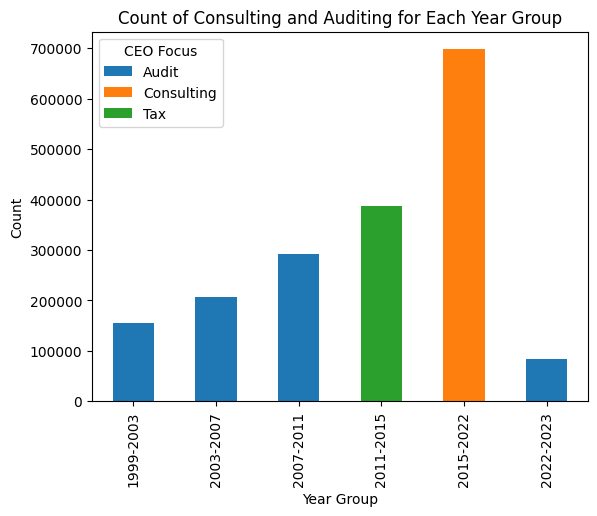

In [ ]:
# bins for start years
bins = [1999, 2003, 2007, 2011, 2015, 2022, 2023]

# create labels for bins
labels = ['1999-2003', '2003-2007', '2007-2011', '2011-2015', '2015-2022', '2022-2023']

# bin the start years
expanded_df['year_group'] = pd.cut(expanded_df['Year'], bins=bins, labels=labels, right=False)

# group by year group and CEO focus, then count the occurrences
counts = expanded_df.groupby(['year_group', 'CEO Focus']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True)

plt.title('Count of Consulting and Auditing for Each Year Group')
plt.xlabel('Year Group')
plt.ylabel('Count')

plt.show()

Above graph is a validation check that CEO focus in expanded_df was labelled correctly. Can cross reference this with ceo df.

In [ ]:
# we can drop year_group column since that was just used for visual purposes in the bar chart
expanded_df.drop(columns=['year_group'], inplace=True)
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit
...,...,...,...,...,...,...,...
2240517,1.374304e+14,11-2021.00,2012,0,1,0,Tax
2240518,1.374304e+14,11-2021.00,2013,0,1,0,Tax
2240519,1.374304e+14,11-2021.00,2014,0,1,0,Tax
2240520,1.374304e+14,11-2021.00,2014,0,1,0,Tax


In [ ]:
# Now need to add in data from lateral, promotion, demotion, analysis
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,11-9199.02,2,3,5,0.400000,Lateral
1,11-2021.00,13-1111.00,59,876,935,0.063102,Demotion
2,11-2021.00,13-1141.00,1,0,1,1.000000,Promotion
3,11-2021.00,13-1161.00,21,63,84,0.250000,Demotion
4,11-2021.00,13-2011.01,29,110,139,0.208633,Demotion
...,...,...,...,...,...,...,...
145,43-3031.00,13-1161.00,1,6,7,0.142857,Demotion
146,43-3031.00,13-2011.01,27,20,47,0.574468,Lateral
147,43-3031.00,13-2011.02,583,102,685,0.851095,Promotion
148,43-3031.00,13-2051.00,3,1,4,0.750000,Promotion


In [ ]:
# Now merge the two dfs: expanded and transitions. To do this need to merge on
# both origin and destination. Need to create a new variable which is the
# occupation for each individual in the next year in the expanded df.
# That would give us the origin and destination needed to merge the tables.
# This allows us to merge in on the occupation pair to classify
# whether any occupation transition is promotion/demotion/lateral.

# sort the df by id and year
df_expanded_sorted = expanded_df.sort_values(by=['ID', 'Year'])

# group by id and shift the onet column by one row to get the next year's occupation
expanded_df['Next_Year_Occupation'] = df_expanded_sorted.groupby('ID')['ONET'].shift(-1)
expanded_df # should still have 2,240,522 rows

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,13-1111.00
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,13-1111.00
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,13-1111.00
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,13-1111.00
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,13-1111.00
...,...,...,...,...,...,...,...,...
2240517,1.374304e+14,11-2021.00,2012,0,1,0,Tax,11-2021.00
2240518,1.374304e+14,11-2021.00,2013,0,1,0,Tax,11-2021.00
2240519,1.374304e+14,11-2021.00,2014,0,1,0,Tax,11-2021.00
2240520,1.374304e+14,11-2021.00,2014,0,1,0,Tax,11-2021.00


In [ ]:
# Let's inspect certain ID's to make sure next yr occupation is correct
filtered_df = expanded_df[expanded_df['ID'] == 36]
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,36.0,13-1111.00,2018,0,1,0,Consulting,13-1111.00
1,36.0,13-1111.00,2019,0,1,0,Consulting,13-1111.00
2,36.0,13-1111.00,2020,0,1,0,Consulting,13-1111.00
3,36.0,13-1111.00,2021,0,1,0,Consulting,13-1111.00
4,36.0,13-1111.00,2022,0,1,0,Audit,13-1111.00
5,36.0,13-1111.00,2023,0,1,0,Audit,13-1111.00
6,36.0,13-1111.00,2024,0,1,0,None,NaN


In [ ]:
# Let's inspect another ID to make sure next yr occupation is correct
filtered_df = expanded_df[expanded_df['ID'] == 1813]
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
11,1813.0,13-2011.02,2007,1,0,1,Audit,13-2011.02
12,1813.0,13-2011.02,2008,1,0,1,Audit,13-2011.02
13,1813.0,13-2011.02,2009,1,0,1,Audit,13-2011.02
14,1813.0,13-2011.02,2010,1,0,1,Audit,13-2011.02
15,1813.0,13-2011.02,2011,1,0,1,Tax,13-2011.02
16,1813.0,13-2011.02,2012,1,0,1,Tax,13-2051.00
17,1813.0,13-2051.00,2012,1,0,0,Tax,13-2051.00
18,1813.0,13-2051.00,2013,1,0,0,Tax,13-2051.00
19,1813.0,13-2051.00,2014,1,0,0,Tax,13-2051.00
20,1813.0,13-2051.00,2015,1,0,0,Consulting,13-2011.02


Looks like next_yr_occupation is correct so now can merge tables to create master dataset.

In [ ]:
# Save both dfs to a csv file so no need to re run prev code chunks

# save expanded df
file_path_expanded = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_expanded_df.gz'
expanded_df.to_csv(file_path_expanded, index=False, compression='gzip') # Needed to zip file because it is too large

# save transitsions df
file_path_transitions = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_transitions_counts_df.csv'
transitions_count.to_csv(file_path_transitions, index=False)

In [ ]:
# reread them back in

# reread expanded df first
file_path_expanded = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_expanded_df.gz'
expanded_df = pd.read_csv(file_path_expanded, compression='gzip')
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,13-1111.00
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,13-1111.00
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,13-1111.00
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,13-1111.00
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,13-1111.00
...,...,...,...,...,...,...,...,...
2240517,1.374304e+14,11-2021.00,2012,0,1,0,Tax,11-2021.00
2240518,1.374304e+14,11-2021.00,2013,0,1,0,Tax,11-2021.00
2240519,1.374304e+14,11-2021.00,2014,0,1,0,Tax,11-2021.00
2240520,1.374304e+14,11-2021.00,2014,0,1,0,Tax,11-2021.00


In [ ]:
# reread transitions count df
file_path_transitions = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_transitions_counts_df.csv'
transitions_count = pd.read_csv(file_path_transitions)
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,11-9199.02,2,3,5,0.400000,Lateral
1,11-2021.00,13-1111.00,59,876,935,0.063102,Demotion
2,11-2021.00,13-1141.00,1,0,1,1.000000,Promotion
3,11-2021.00,13-1161.00,21,63,84,0.250000,Demotion
4,11-2021.00,13-2011.01,29,110,139,0.208633,Demotion
...,...,...,...,...,...,...,...
145,43-3031.00,13-1161.00,1,6,7,0.142857,Demotion
146,43-3031.00,13-2011.01,27,20,47,0.574468,Lateral
147,43-3031.00,13-2011.02,583,102,685,0.851095,Promotion
148,43-3031.00,13-2051.00,3,1,4,0.750000,Promotion


Originally we inner joined expanded df and transitions_count df but the issue with that is we lost so much data and we want the data to have an observation for each individual-year. This is because transitions_count does not take into account if a person stayed at the same occupation, meaning origin and destination never have the same value. Transitions_count only contains data if they transitioned to ANOTHER occupation. So, to keep all the desired data we need to use union instead of inner join. After we union the data, that means some data will not have a categorization of demotion, promotion, or lateral because the transition does not exsit in the transitions_count df, due to having the same occupation. If it is not categorized as one of the three, we would assign it a value of 0, so we don't lose this information when we do the regression analysis.


In [ ]:
# merge the dfs based on two columns
master_df = pd.merge(expanded_df, transitions_count, left_on=['ONET', 'Next_Year_Occupation'], right_on=['Origin', 'Destination'], how='outer')
# This will merge the two dfs based on the specified conditions. The how='outer' parameter
# ensures that all data from both dfs is retained, with NaN values filled in where there are no matches.

master_df.fillna(0,inplace = True) # replace NaNs with 0's

master_df # should have 2,240,522 rows , yes good.

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,13-1111.00,0,0,0.0,0.0,0.0,0.0,0
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,13-1111.00,0,0,0.0,0.0,0.0,0.0,0
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,13-1111.00,0,0,0.0,0.0,0.0,0.0,0
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,13-1111.00,0,0,0.0,0.0,0.0,0.0,0
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,13-1111.00,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,13-1031.00,2011,1,0,0,Tax,13-2099.02,0,0,0.0,0.0,0.0,0.0,0
2240518,9.665394e+13,13-2011.00,1993,0,1,0,0,13-1161.00,0,0,0.0,0.0,0.0,0.0,0
2240519,1.015932e+14,13-2011.00,2018,1,0,0,Consulting,13-1041.00,0,0,0.0,0.0,0.0,0.0,0
2240520,1.088774e+14,13-1031.00,2000,0,1,0,Audit,13-1111.00,0,0,0.0,0.0,0.0,0.0,0


In [ ]:
# Now drop certain columns don't need in master df
columns_to_drop = ['Next_Year_Occupation','Origin','Destination','Count','Other Direction','Total Moves','Ratio']
master_df.drop(columns=columns_to_drop, inplace=True)
master_df # inspect df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Job Move
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,0
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,0
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,0
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,0
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,0
...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,13-1031.00,2011,1,0,0,Tax,0
2240518,9.665394e+13,13-2011.00,1993,0,1,0,0,0
2240519,1.015932e+14,13-2011.00,2018,1,0,0,Consulting,0
2240520,1.088774e+14,13-1031.00,2000,0,1,0,Audit,0


In [ ]:
# Let's see how many rows when job moves = lateral, promotion, demotion, and 0
# filtered_df = master_df[master_df['Job Move'] == 'Lateral'] # 116986 rows
# filtered_df = master_df[master_df['Job Move'] == 'Promotion'] # 39986 rows
# filtered_df = master_df[master_df['Job Move'] == 'Demotion'] # 34202 rows
filtered_df = master_df[master_df['Job Move'] == 0] # 2049348 rows
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Job Move
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,0
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,0
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,0
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,0
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,0
...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,13-1031.00,2011,1,0,0,Tax,0
2240518,9.665394e+13,13-2011.00,1993,0,1,0,0,0
2240519,1.015932e+14,13-2011.00,2018,1,0,0,Consulting,0
2240520,1.088774e+14,13-1031.00,2000,0,1,0,Audit,0


In [ ]:
# Now need to transpose the job moves column

# One-hot encode the 'Job Move' column
job_moves_dummies = pd.get_dummies(master_df['Job Move'])

# Convert boolean values to integers (1s and 0s)
job_moves_dummies = job_moves_dummies.astype(int)

# concatenate the one-hot encoded columns to the original df
master_df = pd.concat([master_df.drop(columns=['Job Move']), job_moves_dummies], axis=1)
master_df # inspect df, should have same amt of rows and it does

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,0,Demotion,Lateral,Promotion
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,1,0,0,0
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,1,0,0,0
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,1,0,0,0
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,1,0,0,0
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,13-1031.00,2011,1,0,0,Tax,1,0,0,0
2240518,9.665394e+13,13-2011.00,1993,0,1,0,0,1,0,0,0
2240519,1.015932e+14,13-2011.00,2018,1,0,0,Consulting,1,0,0,0
2240520,1.088774e+14,13-1031.00,2000,0,1,0,Audit,1,0,0,0


In [ ]:
# inspect tranposed columns
# filtered_rows = master_df[master_df['Lateral'] == 1] # 116986 rows
# filtered_rows = master_df[master_df['Promotion'] == 1] # 39986 rows
# filtered_rows = master_df[master_df['Demotion'] == 1] # 34202 rows
filtered_rows = master_df[master_df[0] == 1] # 2049348 rows
filtered_rows
# this matches the previous number of rows above. So we are good.

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,0,Demotion,Lateral,Promotion
0,3.600000e+01,13-1111.00,2018,0,1,0,Consulting,1,0,0,0
1,3.600000e+01,13-1111.00,2019,0,1,0,Consulting,1,0,0,0
2,3.600000e+01,13-1111.00,2020,0,1,0,Consulting,1,0,0,0
3,3.600000e+01,13-1111.00,2021,0,1,0,Consulting,1,0,0,0
4,3.600000e+01,13-1111.00,2022,0,1,0,Audit,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,13-1031.00,2011,1,0,0,Tax,1,0,0,0
2240518,9.665394e+13,13-2011.00,1993,0,1,0,0,1,0,0,0
2240519,1.015932e+14,13-2011.00,2018,1,0,0,Consulting,1,0,0,0
2240520,1.088774e+14,13-1031.00,2000,0,1,0,Audit,1,0,0,0


In [ ]:
master_df.dtypes

ID                 float64
ONET                object
Year                 int64
Audit_History        int64
Consult_History      int64
Exit                 int64
CEO Focus           object
0                    int64
Demotion             int64
Lateral              int64
Promotion            int64
dtype: object

In [ ]:
# we don't need the column 0 now since it was just a holder to not lose data
column_to_drop = 0
master_df.drop(columns=[column_to_drop], inplace=True)
master_df.dtypes

ID                 float64
ONET                object
Year                 int64
Audit_History        int64
Consult_History      int64
Exit                 int64
CEO Focus           object
Demotion             int64
Lateral              int64
Promotion            int64
dtype: object

In [ ]:
# rearrange the order of columns

# define the desired column order
desired_column_order = ['ID', 'Year','ONET', 'Audit_History', 'Consult_History', 'Exit', 'Lateral', 'Promotion', 'Demotion', 'CEO Focus']
master_df = master_df[desired_column_order]
master_df # inspect df

,ID,Year,ONET,Audit_History,Consult_History,Exit,Lateral,Promotion,Demotion,CEO Focus
0,3.600000e+01,2018,13-1111.00,0,1,0,0,0,0,Consulting
1,3.600000e+01,2019,13-1111.00,0,1,0,0,0,0,Consulting
2,3.600000e+01,2020,13-1111.00,0,1,0,0,0,0,Consulting
3,3.600000e+01,2021,13-1111.00,0,1,0,0,0,0,Consulting
4,3.600000e+01,2022,13-1111.00,0,1,0,0,0,0,Audit
...,...,...,...,...,...,...,...,...,...,...
2240517,8.839043e+13,2011,13-1031.00,1,0,0,0,0,0,Tax
2240518,9.665394e+13,1993,13-2011.00,0,1,0,0,0,0,0
2240519,1.015932e+14,2018,13-2011.00,1,0,0,0,0,0,Consulting
2240520,1.088774e+14,2000,13-1031.00,0,1,0,0,0,0,Audit


In [ ]:
# save this df as a csv file now
path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Deloitte/deloitte_master_dataset.csv'
master_df.to_csv(path, index=False)